# Using the Trainer

In [1]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

torch      : 2.0.0
lightning  : 1.9.0
torchvision: 0.15.1



In [2]:
import lightning as L

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import torchmetrics
from torchvision import datasets, transforms
import torchvision


import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [3]:
class MnistDataModule(L.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=0):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers

    def prepare_data(self):
        datasets.MNIST(root=self.data_path, download=True)
        return

    def setup(self, stage=None):
        # Note transforms.ToTensor() scales input images
        # to 0-1 range
        train = datasets.MNIST(
            root=self.data_path,
            train=True,
            transform=transforms.ToTensor(),
            download=False,
        )

        self.test = datasets.MNIST(
            root=self.data_path,
            train=False,
            transform=transforms.ToTensor(),
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[55000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader

In [4]:
dm = MnistDataModule()

# Model

In [5]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [6]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)

### Initialize Model

In [7]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
        return optimizer

# Logger

In [8]:
from lightning.pytorch.loggers import CSVLogger

In [9]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=3,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    accelerator="cpu",
    devices=1,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebastian/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [10]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 84.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
84.1 K    Trainable params
0         Non-trainable params
84.1 K    Total params
0.336     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/sebastian/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastian/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [11]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/sebastian/miniforge3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9571999907493591     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9571999907493591}]

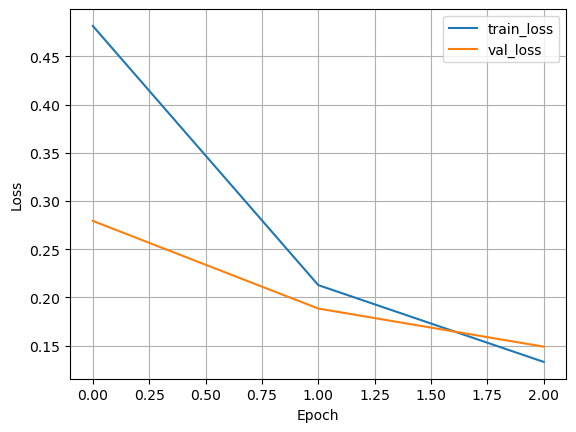

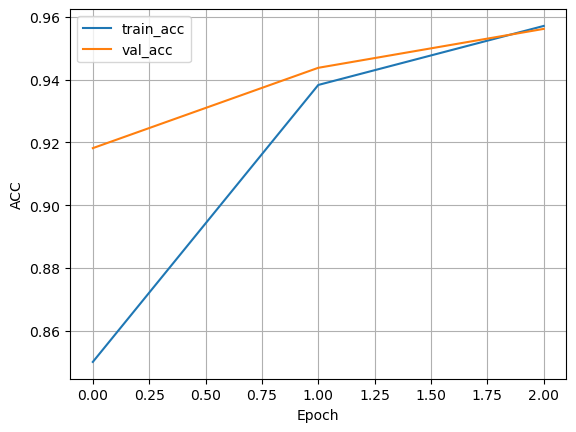

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()